In [3]:


!pip install datasets pillow matplotlib --quiet

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# setting parameters
IMG_WIDTH, IMG_HEIGHT = 128, 32
MAX_LABEL_LENGTH = 110


In [5]:
# loading in the dataset IAM
dataset = load_dataset("Teklia/IAM-line")
sample = dataset['train'][0]
print("IAM Sample text:", sample['text'])
sample['image'].show()

# function to preprocess IAM
def preprocess_image_pil(image):
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image = np.array(image.convert("L")) / 255.0  
    return np.expand_dims(image, axis=-1)

iam_texts = [ex['text'] for ex in dataset['train']]

# the tokenizer for IAM
# Note: Tokenizer assigns tokens starting at 1, and 0 will be used for padding.
tokenizer = Tokenizer(char_level=True, lower=False, filters='')
tokenizer.fit_on_texts(iam_texts)

M = max(tokenizer.word_index.values())
# We remap valid tokens to range 0 ... M-1. Then we reserve index M as the blank.
NUM_CLASSES = M + 1
print("Computed NUM_CLASSES (including blank classes):", NUM_CLASSES)

IAM Sample text: put down a resolution on the subject
Computed NUM_CLASSES (including blank classes): 80


In [8]:
# processing the images and labels for IAM dataset
train_images = np.array([preprocess_image_pil(ex['image']) for ex in dataset['train']])

# Get label sequences (values are in [1, M])
train_labels = tokenizer.texts_to_sequences(iam_texts)

# Pad with 0 (which is also our pad value)
train_labels = pad_sequences(train_labels, maxlen=MAX_LABEL_LENGTH, padding='post', value=0)

# Remap: subtract 1 from nonzero entries so that valid tokens become 0..M-1.
# (Padded zeros remain 0 – later we compute label lengths by counting nonzeros.)
train_labels = np.where(train_labels != 0, train_labels - 1, 0)

print("IAM images shape:", train_images.shape)
print("IAM labels shape:", train_labels.shape)

IAM images shape: (6482, 32, 128, 1)
IAM labels shape: (6482, 110)


In [10]:
samples_image_folder = "jpg"  
samples_label_file = "/Users/shikhusanjel/Desktop/CNNTEST/SamplePassage.txt" #this is the our passage text 
#copied into a txt file i made and put the file to it in this code

# reading the labels line by line
with open(samples_label_file, "r", encoding="utf-8") as f:
    custom_labels = [line.strip() for line in f.readlines()]

# list and sort collected data image paths 
image_paths = sorted([
    os.path.join(samples_image_folder, f)
    for f in os.listdir(samples_image_folder)
    if f.lower().endswith(".jpg")
])
print("Custom image count:", len(image_paths))
print("Custom label count:", len(custom_labels))

def preprocess_image_from_path(path):
    img = load_img(path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img) / 255.0
    return img

custom_images_processed = np.array([preprocess_image_from_path(p) for p in image_paths])
custom_sequences = tokenizer.texts_to_sequences(custom_labels)
custom_sequences_padded = pad_sequences(custom_sequences, maxlen=MAX_LABEL_LENGTH, padding='post', value=0)
custom_sequences_padded = np.where(custom_sequences_padded != 0, custom_sequences_padded - 1, 0)

print("Custom images shape:", custom_images_processed.shape)
print("Custom labels shape:", custom_sequences_padded.shape)

Custom image count: 63
Custom label count: 63
Custom images shape: (63, 32, 128, 1)
Custom labels shape: (63, 110)


In [12]:
# merging the IAM and the custom data
merged_images = np.concatenate([train_images, custom_images_processed], axis=0)
merged_labels = np.concatenate([train_labels, custom_sequences_padded], axis=0)
print("Merged images shape:", merged_images.shape)
print("Merged labels shape:", merged_labels.shape)

Merged images shape: (6545, 32, 128, 1)
Merged labels shape: (6545, 110)


In [14]:
# split the data into training and testing
X_train, X_val, y_train, y_val = train_test_split(
    merged_images, merged_labels, test_size=0.2, random_state=42, shuffle=True
)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (5236, 32, 128, 1) (5236, 110)
Validation set: (1309, 32, 128, 1) (1309, 110)


In [16]:
#first run through of training merged data CELL BLOCK 
# model inputs
input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='image_input')
labels_input = layers.Input(name='label', shape=(MAX_LABEL_LENGTH,), dtype='int32')

# CNN + BiLSTM Architecture
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Reshape((-1, 128))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Dense(NUM_CLASSES, activation='softmax')(x)

In [18]:
# CTC loss using a lambda layer
def ctc_lambda_func(args):
    y_pred, labels = args
    # Prediction lengths: each sample has the same time dimension.
    time_steps = tf.cast(tf.shape(y_pred)[1], tf.float32)
    input_length = tf.ones((tf.shape(y_pred)[0], 1), dtype=tf.float32) * time_steps
    # Actual label length: count nonzero (i.e. valid) labels per sample.
    label_length = tf.cast(tf.math.count_nonzero(labels, axis=1, keepdims=True), dtype=tf.float32)
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([x, labels_input])

# final model
ctc_model = Model(inputs=[input_img, labels_input], outputs=loss_out, name="CTC_Model")
ctc_model.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred)

dummy_train = np.zeros((len(X_train), 1))
dummy_val = np.zeros((len(X_val), 1))

In [20]:
# model training
history = ctc_model.fit(
    [X_train, y_train],
    dummy_train,
    validation_data=([X_val, y_val], dummy_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 47s 279ms/step - loss: 224.9531 - val_loss: 114.2822
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 46s 283ms/step - loss: 113.2030 - val_loss: 113.9442
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - loss: 113.6166 - val_loss: 113.8231
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - loss: 112.2196 - val_loss: 113.6954
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - loss: 112.6157 - val_loss: 113.4736
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 296ms/step - loss: 112.1749 - val_loss: 113.4150
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - loss: 112.2373 - val_loss: 113.1688
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - loss: 112.1616 - val_loss: 108.8685
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - loss: 106.8792 - val_loss: 107.1635
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - loss: 105.0729 - val_loss: 106.6576
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - loss: 104.5

In [22]:
# a separate model that maps the image input to predictions (the softmax outputs)

# Get the image input from our original model
# (Note: our original model 'ctc_model' uses two inputs, but the prediction is based solely on the image input.)
prediction_model = Model(inputs=input_img, outputs=x)
# decode predictions using TensorFlow their built in CTC decoder
def decode_predictions(preds, charset):
    # preds: output from the prediction model, shape (batch, time_steps, NUM_CLASSES)
    # The 'input_length' for each sample is the full length of the time dimension:
    input_length = np.ones(preds.shape[0]) * preds.shape[1]
    # Use greedy CTC decode:
    decoded, log_prob = tf.keras.backend.ctc_decode(preds, input_length, greedy=True)
    decoded_sequences = decoded[0].numpy()
    results = []
    for seq in decoded_sequences:
        # Remove any padding or repeated characters:
        # Since we remapped token values earlier, our tokens are in [0, M-1]. To convert back:
        result = ""
        for token in seq:
            if token == -1:
                continue
            # Token value 0 corresponds to the lowest valid character.
            # Our tokenizer originally had word_index starting at 1,
            # and we subtracted one; so we add 1 back to look up the character.
            char = charset.get(token + 1, "")
            result += char
        results.append(result)
    return results

# build a reverse mapping dictionary from token index to character 
#(this is in order to read the test images and decode their outputs to evalluate them
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
index_to_char = {index: char for char, index in tokenizer.word_index.items()}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


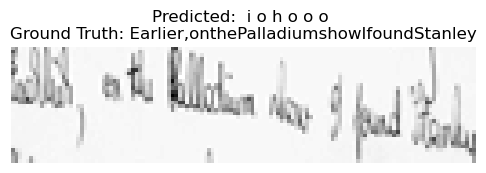

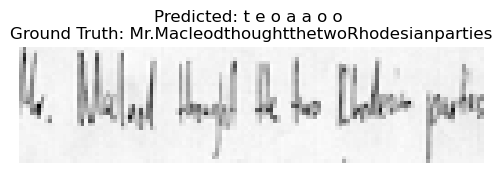

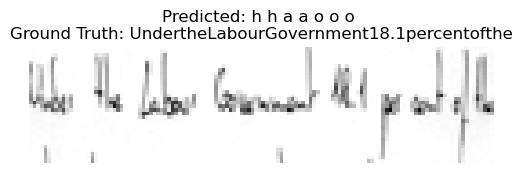

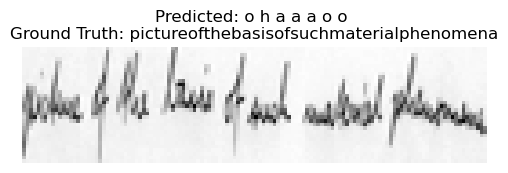

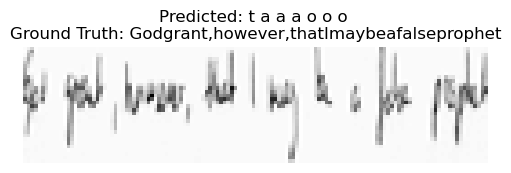

In [24]:
#testing
import matplotlib.pyplot as plt

num_samples = 5
sample_imgs = X_val[:num_samples]
sample_labels = y_val[:num_samples]

#get the predictions
preds = prediction_model.predict(sample_imgs)

#decoding the predictions 
decoded_texts = []
for pred in preds:
    # CTC decode the prediction for a single sample
    input_len = np.array([pred.shape[0]])
    # The ctc_decode expects batch shape; we add batch dimension.
    decoded, _ = tf.keras.backend.ctc_decode(np.expand_dims(pred, axis=0), input_length=input_len, greedy=True)
    decoded_seq = decoded[0].numpy()[0]
    text = ""
    for token in decoded_seq:
        # Skip blank tokens (if any); token values range from 0 to (M-1)
        if token < 0: 
            continue
        text += index_to_char.get(token + 1, "")
    decoded_texts.append(text)

# predictions compared to the ground truth
for i in range(num_samples):
    plt.figure(figsize=(6, 2))
    plt.imshow(sample_imgs[i].squeeze(), cmap='gray')
    plt.title(f"Predicted: {decoded_texts[i]}\nGround Truth: " +
              "".join([index_to_char.get(token+1, "") for token in sample_labels[i] if token > 0]))
    plt.axis('off')
    plt.show()

In [ ]:
#fine tuning models start here (added Dropout to LSTM here, add batch normalization, and change learning rate)

In [26]:
# model inputs
input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='image_input')
labels_input = layers.Input(name='label', shape=(MAX_LABEL_LENGTH,), dtype='int32')

# CNN + BiLSTM architecture (changed)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Reshape((-1, 128))(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1))(x)
x = layers.Dense(NUM_CLASSES, activation='softmax')(x)



In [28]:
# CTC loss using a lambda layer
def ctc_lambda_func(args):
    y_pred, labels = args
    # Prediction lengths: each sample has the same time dimension.
    time_steps = tf.cast(tf.shape(y_pred)[1], tf.float32)
    input_length = tf.ones((tf.shape(y_pred)[0], 1), dtype=tf.float32) * time_steps
    # Actual label length: count nonzero (i.e. valid) labels per sample.
    label_length = tf.cast(tf.math.count_nonzero(labels, axis=1, keepdims=True), dtype=tf.float32)
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([x, labels_input])

# final model
ctc_model = Model(inputs=[input_img, labels_input], outputs=loss_out, name="CTC_Model")
ctc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=lambda y_true, y_pred: y_pred)


dummy_train = np.zeros((len(X_train), 1))
dummy_val = np.zeros((len(X_val), 1))




In [ ]:
# model training
history = ctc_model.fit(
    [X_train, y_train],
    dummy_train,
    validation_data=([X_val, y_val], dummy_val),
    epochs=20,
    batch_size=32
)

In [ ]:
#adding more fine tuning here

In [30]:
# model inputs
input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='image_input')
labels_input = layers.Input(name='label', shape=(MAX_LABEL_LENGTH,), dtype='int32')

# CNN + BiLSTM architecture (changed)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Reshape((-1, 128))(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1))(x)
x = layers.Dense(NUM_CLASSES, activation='softmax')(x)



In [32]:
# CTC loss using a lambda layer
def ctc_lambda_func(args):
    y_pred, labels = args
    # Prediction lengths: each sample has the same time dimension.
    time_steps = tf.cast(tf.shape(y_pred)[1], tf.float32)
    input_length = tf.ones((tf.shape(y_pred)[0], 1), dtype=tf.float32) * time_steps
    # Actual label length: count nonzero (i.e. valid) labels per sample.
    label_length = tf.cast(tf.math.count_nonzero(labels, axis=1, keepdims=True), dtype=tf.float32)
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([x, labels_input])

# final model
ctc_model = Model(inputs=[input_img, labels_input], outputs=loss_out, name="CTC_Model")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
ctc_model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)



dummy_train = np.zeros((len(X_train), 1))
dummy_val = np.zeros((len(X_val), 1))




In [34]:
# model training
history = ctc_model.fit(
    [X_train, y_train],
    dummy_train,
    validation_data=([X_val, y_val], dummy_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - loss: 246.9678 - val_loss: 1143.9130
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 63s 383ms/step - loss: 111.2936 - val_loss: 1175.9661
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 389ms/step - loss: 110.1056 - val_loss: 129.1566
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 411ms/step - loss: 106.7458 - val_loss: 107.9441
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 407ms/step - loss: 104.8153 - val_loss: 107.3999
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 406ms/step - loss: 103.8033 - val_loss: 108.5578
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - loss: 103.0168 - val_loss: 105.2075
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 395ms/step - loss: 102.4872 - val_loss: 111.0084
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 400ms/step - loss: 102.7500 - val_loss: 105.9198
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 401ms/step - loss: 102.3584 - val_loss: 104.8066
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 400ms/step - loss: 101